# Student Name: Huynh Truong Tu
 Below is my assignment for Sprint5's "SVM"



----------------------------------------------------------------------------------------------------------------------------------------

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample Code

In [47]:
class SampleSVM():
    def __init__(self, num_iter = 100, lr = 0.01, kernel = 'linear', gamma = 1, d = 1, theta = 0, threshold = 1e-5, verbose = False, debug = False):
        self.num_iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.gamma = gamma
        self.d = d
        self.theta = theta
        self.threshold = threshold
        self.verbose = verbose 
        self.debug = debug

    def kernel_function(self,Xi,Xj):
        if self.kernel == 'poli':
            self.gamma = 1
            self.d = 2
            self.theta = 1
        return (self.gamma * np.dot(Xi,Xj.T) + self.theta)**self.d
    def update_lambda(self,X,y):
      #! sample code  
      for i in range(len(X)):
        total = 0
        for j in range(len(X)):
          total += self.lagrange_multiplier[j] * y[i] * y[j] * self.kernel_function(X[i], X[j])
        self.lagrange_multiplier[i] += self.lr * (1- total)

        if self.lagrange_multiplier[i] < 0:
          self.lagrange_multiplier[i] = 0
    def fit(self,X,y,X_val = None, y_val = None):
        self.labels = np.unique(y)
        y = np.where(y==self.labels[0],-1,1)
        
        #Prep part
        np.random.seed(2000)
        self.lagrange_multiplier = np.random.rand(y.shape[0]) 
        # self.lagrange_multiplier = np.ones(y.shape)

        if self.debug:
            print('Init Larg: ')
            print(self.lagrange_multiplier)
        for i in range(self.num_iter):
            self.update_lambda(X,y)
            if self.debug:
                print('Iter: ',i,'Lagrange : ')
                print(self.lagrange_multiplier)

        self.sv_index = self.lagrange_multiplier > self.threshold
        self.support_vectors_ = X[self.sv_index]
        self.n_support_vectors = self.support_vectors_.shape[0]
        self.sv_lagrange = self.lagrange_multiplier[self.sv_index]
        self.sv_label = y[self.sv_index]

        if self.verbose:
            print('n vec: ', self.n_support_vectors)
            
            result = pd.DataFrame(
                data = {
                    'SV: ': [str(x) for x in self.support_vectors_],
                    'Lagrange: ' : self.sv_lagrange.ravel(),
                    'Label: ': self.sv_label.ravel(),
                }, index = list(np.where(self.sv_index))
            )
            print(result)

    def predict(self,X):
        y_pred = np.zeros(len(X))
        for i in range(len(X)):
            total = 0
            for j in range(self.n_support_vectors):
                total += self.sv_lagrange[j] * self.sv_label[j]  * self.kernel_function(X[i],self.support_vectors_[j])

            if total > 0:
                y_pred[i] = self.labels[1]
            else:
                y_pred[i] = self.labels[0]
        return y_pred



# Prototype

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, degree = 2, verbose=False, debug = False, improved = False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.debug = debug
        self.improved = improved
        self.degree = degree
    def kernel_function(self,Xi,Xj):
      if self.kernel == 'linear':
        result = Xi @ Xj.T
      if self.kernel == 'simple_poli':
        result = (Xi @ Xj.T + 1)**self.degree

      # print('Kernel shape: ',result.shape)
      return result
    def fit(self, X, y, X_val=None, y_val=None):

        #Prep part
        np.random.seed(2000)
        self.lagrange_multiplier = np.random.rand(X.shape[0],1) #this can be dim 1 or 0
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1) if y_val else None
        self.labels = np.unique(y)

        if self.verbose:
          print('Xshape: ', X.shape, 'yshape: ', y.shape)
          if X_val:
            print('XValshape: ', X_val.shape, 'yvalshape: ', y_val.shape)

          print('Labels: ', self.labels)
        
        #Learn part
        if self.debug:
          print('Origin lagrange_multiplier: ')
          print(self.lagrange_multiplier.ravel())
        for i in range(self.iter):
          self.update_lagrange(X,y)
          if self.debug:
            print('Current Lar: ')
            print(self.lagrange_multiplier.ravel())
              
        
        #get sv part
        sv_index = []
        for idx, l in enumerate(self.lagrange_multiplier):
          if l > self.threshold: sv_index.append(idx)
        self.support_vectors_ = X[sv_index]
        self.n_support_vectors = len(sv_index)
        self.sv_lagrange = self.lagrange_multiplier[sv_index]
        self.sv_labels = y[sv_index]

        #validation part
        self.train_score = self.validate(X,y)
        self.valid_score = self.validate(X_val,y_val) if X_val else {'Score':'No validation set!'}


        # verbose part
        if self.verbose:
            result = pd.DataFrame({
              # 'SV Index': np.array(sv_index).reshape(-1,1),
              'support_vectors':[str(x) for x in self.support_vectors_],
              'label': self.sv_labels.ravel(),
              'L-multiple: ' : self.sv_lagrange.ravel()
            }, index = sv_index)
            print('Number of SVs: ', self.n_support_vectors)
            print(result)
            print('Training Score: ')
            print(pd.DataFrame(self.train_score, index = [0]))
            print('Validation Score: ')
            print(pd.DataFrame(self.valid_score, index = [0]))
            if self.debug: print('LagrangeMultiplier: ', self.lagrange_multiplier)
            
    def validate(self,X_val,y_val):
      pred = self.predict(X_val)
      acc = accuracy_score(pred,y_val)
      pre = precision_score(pred,y_val)
      rec = recall_score(pred,y_val)
      f1 = f1_score(pred,y_val)
      return {'Accuracy:': acc, 'Precision: ': pre, 'Recall: ':rec , 'F1-Score: ':f1}
      
    def update_lagrange(self,X,y):

      if self.improved:
        lm = self.lagrange_multiplier
        kernel_matrix = self.kernel_function(X,X) # precalculate, can put this outside the learning loop also!
        for i in range(lm.shape[0]):
          if lm[i] < 0:
            print('Lagrange multiple is less than zero: ', lm[i], ' index: ', i)
          temp = y * lm * kernel_matrix[i].reshape(-1,1)
          gradient_i = 1 - y[i]* temp.sum()
          lm[i] = max(0, lm[i] + self.lr * gradient_i)
        return



      lm = self.lagrange_multiplier
      for i in range(lm.shape[0]): #! update each lagrange multiple
        temp = 0
        #calc sum
        for j in range(lm.shape[0]):
          # if i == j: continue
          temp += y[i]* lm[j] * y[j] * self.kernel_function(X[i], X[j])
          # print(self.kernel_function(X[i],X[j]))
        #update
        lm[i] = max(0,lm[i] + self.lr * (1 - temp))

    def predict(self, X):
      if self.improved:
        #improved prediction code
        fx = self.kernel_function(X,self.support_vectors_) @ (self.sv_lagrange * self.sv_labels)
        get_label = np.vectorize(lambda x: self.labels[0] if x<0 else self.labels[1])
        return get_label(fx)
        
      #prep
      result = np.zeros((X.shape[0],1))
      #predict 
      for i in range(X.shape[0]):
        result[i] = self.predict_x(X[i])
      return result
    def predict_x(self,x):
      fx = 0
      for i in range(self.n_support_vectors):
        fx += self.sv_lagrange[i] * self.sv_labels[i] * self.kernel_function(x, self.support_vectors_[i])
      get_label = lambda x:  self.labels[0] if fx < 0 else self.labels[1]
      return get_label(fx)

# Graphing Code

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,x_test = None, y_test = None, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue']
    contourf_color =  ['pink', 'skyblue']
    n_class = 2

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label='Train: '+ target_names[i], marker='o', alpha = 0.3)
    if not x_test is None:
        for i,target in enumerate(set(y_test)):
            plt.scatter(x_test[y_test==target][:, 0], x_test[y_test==target][:, 1], s=10, color=scatter_color[i], label= 'Test: ' +target_names[i], marker='o')
    #!plot svs
    plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],color = 'yellow',s=80, label = 'SV')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

# My Test

Xshape:  (4, 2) yshape:  (4, 1)
Labels:  [-1  1]
Number of SVs:  3
  support_vectors  label  L-multiple: 
0           [1 1]     -1    143.205821
1           [2 1]     -1      2.428571
3           [2 2]      1     73.531482
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0       0.75          1.0  0.666667         0.8
Validation Score: 
                Score
0  No validation set!
Prediction:  [ 1 -1  1  1]
----------------------
[LibSVM]SV: 
[[1. 1.]
 [2. 1.]
 [1. 2.]
 [2. 2.]]
Lambda: 
[[1. 1. 1. 1.]]
My model: 


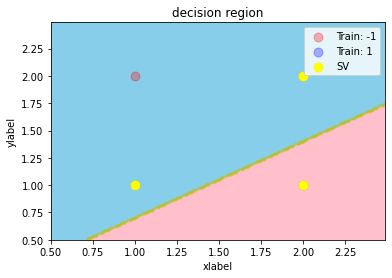

Sklearn: 


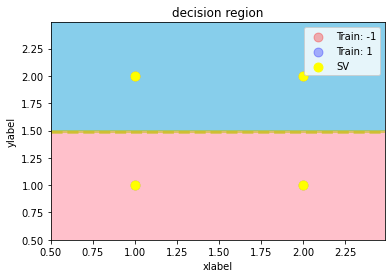

In [50]:
from sklearn.svm import SVC
ssvm = ScratchSVMClassifier(1000,0.1,verbose = True,debug = False, improved = True)
x = np.array([[1,1],
    [2,1],
    [1,2],
    [2,2]])
y = np.array([-1,-1,1,1])
ssvm.fit(x,y)
print('Prediction: ',ssvm.predict(x).ravel())


print('----------------------')
svc = SVC(kernel = 'linear', max_iter = 1000, verbose = True, tol = 1e-5)
svc.fit(x,y)
svc.predict(x)
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

print('My model: ')
decision_region(x,y,ssvm,target_names = ['-1', '1'])
print('Sklearn: ')
decision_region(x,y,svc, target_names = ['-1', '1'])

# Problem 1 - 2 - 3 - 4
I think I can report them together

In [51]:
# Create a data set
np.random.seed(1312451732)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])
#
print('Result: ')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
model = ScratchSVMClassifier(100,0.01,verbose = True, improved= True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))
#
svc = SVC(kernel = 'linear', max_iter = 100, verbose = True, tol = 1e-5)
print('Sklearn Result:')
svc.fit(x_train,y_train)
pred = svc.predict(x_test)
print(confusion_matrix(pred, y_test))
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

Result: 
Xshape:  (400, 2) yshape:  (400, 1)
Labels:  [-1  1]
Number of SVs:  9
               support_vectors  label  L-multiple: 
3    [-1.10706813  0.66963635]      1      0.020590
21   [ 0.18912044 -1.64637154]     -1      0.004049
36   [ 0.21959023 -1.29333656]     -1      0.158017
126  [-0.01362841  1.78717345]      1      0.019144
128    [1.51431578 0.22135173]     -1      0.245577
218  [-0.18375642 -2.0285859 ]     -1      0.001475
236  [ 0.00663177 -1.23366492]     -1      0.293028
249  [ 1.593264   -0.08705822]     -1      0.052629
328  [-1.46050912  0.17071654]      1      0.076236
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0        1.0          1.0       1.0         1.0
Validation Score: 
                Score
0  No validation set!
[[53  0]
 [ 0 47]]
Sklearn Result:
[LibSVM][[53  0]
 [ 0 47]]
SV: 
[[ 0.00663177 -1.23366492]
 [-1.46050912  0.17071654]]
Lambda: 
[[0.48487321 0.48487321]]


# Problem 5 - Visualize Hyperplane


My model: 


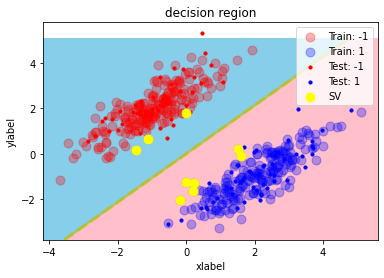

Sklearn: 


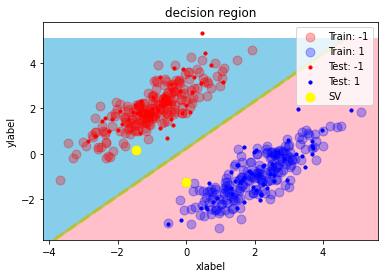

In [52]:
print('My model: ')
decision_region(x_train,y_train,model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)
print('Sklearn: ')
decision_region(x_train,y_train,svc, target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

# Problem 6 - Polinomial Kernel

Circle data set

Text(0, 0.5, '$x_2$')

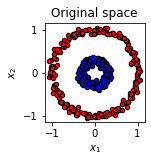

In [61]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=400, factor=.3, noise=.05)
plt.figure()
plt.subplot(2, 2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1


plt.scatter(X[reds, 0], X[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue", s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [62]:
y[y==0] = -1
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
model = ScratchSVMClassifier(100,0.01,verbose = True, improved= True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))

Xshape:  (320, 2) yshape:  (320, 1)
Labels:  [-1  1]
Number of SVs:  320
               support_vectors  label  L-multiple: 
0      [0.29634972 0.90704607]     -1      1.641564
1      [0.15295882 0.22241754]      1      1.532342
2    [-0.98309799 -0.36270374]     -1      1.276949
3    [-0.32416715 -0.19263061]      1      1.409273
4    [ 0.49817344 -0.9068819 ]     -1      1.484542
..                         ...    ...           ...
315  [-0.22946479  0.1611501 ]      1      1.073313
316    [0.57556278 0.93562138]     -1      1.433005
317  [-0.23698858  0.19420543]      1      1.969891
318  [ 0.45552607 -0.93096615]     -1      1.464709
319  [ 0.0316127  -0.31210963]      1      1.250193

[320 rows x 3 columns]
Training Score: 
   Accuracy:  Precision:   Recall:   F1-Score: 
0    0.51875     0.503067  0.529032    0.515723
Validation Score: 
                Score
0  No validation set!
[[16 16]
 [27 21]]


My model: 


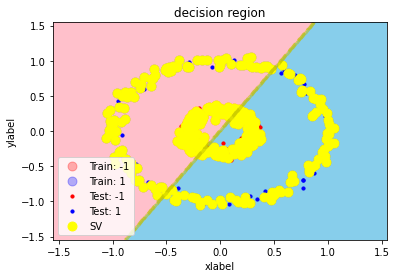

In [63]:
print('My model: ')
decision_region(x_train,y_train,model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

Xshape:  (320, 2) yshape:  (320, 1)
Labels:  [-1  1]
Number of SVs:  33
               support_vectors  label  L-multiple: 
3    [ 0.24257339 -0.33134365]      1      1.004241
20   [ 0.70769062 -0.62143549]     -1      0.151924
23     [0.3530203  0.10672335]      1      0.551326
28   [-0.87703721  0.24743816]     -1      0.912729
31   [ 0.33514636 -0.12391184]      1      0.032229
49   [ 0.30569568 -0.18251791]      1      0.242562
60   [-0.34142817  0.07135816]      1      0.058450
61   [-0.08989807 -0.35367704]      1      0.537617
62   [-0.36396003 -0.12107275]      1      0.945011
80   [-0.11445481 -0.32969475]      1      0.377474
88   [ 0.35785574 -0.01333177]      1      0.163957
105  [-0.00079129 -0.36120524]      1      0.640017
111  [-0.10100022  0.36517202]      1      0.102908
112  [-0.45631839 -0.71927443]     -1      1.151682
116    [0.0308831  0.92237194]     -1      0.186222
123  [-0.34870012  0.1053631 ]      1      0.487188
130  [ 0.01051148 -0.39522793]      1      1

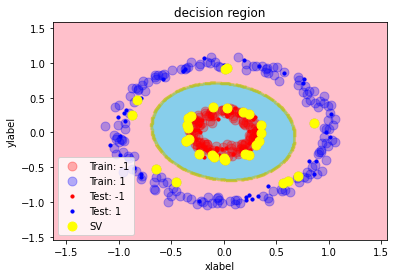

In [56]:
model = ScratchSVMClassifier(1000,0.01,verbose = True, improved= True, kernel = 'simple_poli')
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))
print('New model: ')
decision_region(x_train,y_train,model,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

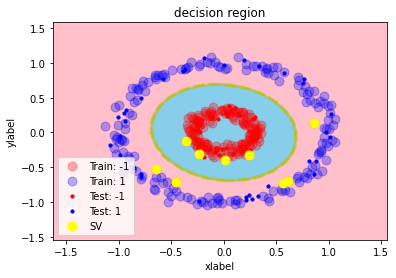

In [57]:
svc = SVC(kernel = 'poly', degree = 2)
svc.fit(x_train,y_train)
decision_region(x_train,y_train,svc,target_names = ['-1', '1'], x_test = x_test, y_test = y_test)

Conclusion:
- I can see that the old model & sample model are similar in term of calculation

----------------------------------------------------------------------------------------------------------------------------------------------

This is the end of my assignment, thank you for reading!